In [1]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities

C:\Users\AMRINA\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train = pd.read_csv("data/resep_dataset2.csv")
train.Bahan.head()

0    Ayam, potong jadi 10 bagian  -  900 gram Garam...
1    Tepung tapioka  -  150 gram Tepung terigu  -  ...
2    Kangkung  -  1 ikat Kacang panjang  -  1 ikat ...
3    BAHAN 1: Kuning telur  -  4 butir Minyak goren...
4    Telur  -  4 butir Gula pasir  -  70 gram Emuls...
Name: Bahan, dtype: object

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   1353 non-null   object
 1   Url     1353 non-null   object
 2   Bahan   1353 non-null   object
 3   Step    1353 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [5]:
def clean_number(text):
    text = re.sub(r'\w*\d+\w*', '', str(text))
    return text

In [6]:
#casefolding
def token_lower(text):
    text = ''.join(str(text)).lower() # lowercase text
    return text

#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

#menghapus double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")


In [7]:
#stopword
#clean stopwords
stopwords_indonesian = set(stopwords.words('indonesian'))

takaran = ['gram', 'sdt', 'sdm', 'buah', 'ml', 'mililiter', 'cup', 'gelas', 'tsp', 'tbsp', 'liter', 'g', 'kg',
           'kilogram', 'pound', 'ons', 'pint', 'pt', 'c', 'celcius', 'f', 'fahrenheit', 'derajat', 'm', 'meter',
           'mm', 'milimeter', 'ruas', 'cm', 'centimeter', 'senti', 'centi', 'siung', 'lembar', 'tangkai', 'batang',
           'butir', 'slice', 'keping', 'kotak', 'papan', 'genggam', 'sejumput', 'bungkus', 'sachet', 'dcc', 'piring',
           'cincin', 'grambahan', 'sendok', 'porsi', 'kantung', 'kantong', 'scoop', 'skup', 'scop', 'loyang', 'segenggam',
           'buntil', 'ikat', 'double', 'botol', 'pack', 'siung','diameter', 'ekor', 'kuntum', 'bonggol']

word_to_remove = ['garam', 'minyak', 'bahan', 'a', 'potong', 'ikat', 'pasir', 'goreng', 'optional', 'butir', 'jam',
                  'setengah', 'tua', 'es', 'cincang', 'halus', 'memarkan', 'secukupnya', 'rajang', 'kasar', 'sampai',
                  'bumbu', 'kuah', 'ambil', 'matang', 'belah', 'bulat', 'sangrai', 'jari', 'mentah', 'air',
                  'lihat', 'resep', 'versi', 'rasa', 'bunda', 'iris', 'suwir', 'lengkap', 'rendam', 'isi', 'dadu',
                  'tiris', 'panas', 'rebus', 'perasan', 'semalaman', 'tabur', 'pakai', 'buang', 'tumis', 'rebusan',
                  'merebus', 'instan', 'hangat', 'petik', 'korek', 'plastik', 'pilih', 'seduh', 'suhu', 'ruang',
                  'siangi', 'cuci', 'hancur', 'empuk', 'segar', 'celup', 'sobek', 'dingin', 'tengah', 'lebar', 'lidi',
                  'didih', 'bentuk', 'ulek', 'remas', 'sisa', 'larut', 'siram', 'opsional', 'cetak', 'tiris',
                  'perasannya', 'campur', 'lumur', 'ayak', 'menyemat', 'filling', 'orak', 'arik', 'cairkan', 'menit','air',
                  'ekorbumbu', 'buahkuah', 'sisir', 'adon', 'tumis', 'encerkan', 'oles', 'sela', 'tambah', 'lelehkan', 'serong', 
                  'cair', 'geprek', 'tipis', 'butirkuah', 'adon', 'rendam', 'tumbuk', 'lengkap', 'selera', 'sesuai', 'b', 'blender', 'of',
                  'topping', 'sdmbahan', 'tusuk', 'mltopping', 'diblender', 'lapis', 'spread', 'biar', 'encer', 'kasir', 'utuh', 'larutkan',
                  'simpukan', 'simpul', 'kocok', 'kocock', 'lepas', 'tabur', 'konsistensi', 'duri', 'goreng', 'minyak', 'rekat', 'makan',
                  'tumis', 'endapan', 'peta', 'sdmcuko', 'tetes', 'uleg', 'sdmisi', 'kupas', 'sdmuleg', 'beserta', 'berseta', 'sebentar',
                  'berat', 'bola', 'basah', 'bilas', 'buahsaus', 'kapal', 'selam', 'gurih', 'pisah', 'bantu', 'suir', 'hancur', 'tangan',
                  'celup', 'hias', 'gepeng', 'serut', 'sdtsaus', 'sdtbaluran', 'formula', 'secukupnyaisian', 'gramisi', 'sdttopping', 'pipil',
                  'lauk', 'pecel', 'hancur', 'baluran', 'didih', 'papanpelapis', 'ampas', 'siungbumbu', 'dibagi', 'bagi', 'suir', 'sdtlainnya',
                  'buahlainnya', 'bagus', 'kualitas', 'sejumputkulit', 'tetessaus', 'putus', 'larut', 'olesisian', 'dimemarkan', 'memar', 
                  'menyerong', 'iris', 'kerat', 'buahbahan', 'gramlapisan', 'panas', 'secukupnyaperendam', 'buahpencelup', 'basic', 'hasil',
                  'sdtperendam', 'mengungkep', 'mengunkep', 'aduk', 'mlsaus', 'secukupnyabiang', 'lumur', 'mlbahan', 'sdtbahan', 'lumuran',
                  'sejumpuhkuah', 'sdmserundeng', 'sdtolesan', 'mltaburan', 'taburan', 'tabur', 'cepat', 'kolcuciwis', 'hangatkan', 'lembarbumbu',
                  'sdttaburan', 'sdmtaburan', 'gramtaburan', 'robek', 'sd', 'tlapisan', 'kasur', 'tali', 'lembarpudding', 'alas', 'lentur',
                  'mlfilling', 'sdtgarnish', 'garnish', 'sdtsambal', 'lembartaburan', 'minimal', 'secukupnyalapisan', 'kuku', 'jaripelengkap',
                  'diseduh', 'batangsaus', 'acting', 'secukupnyatumisan', 'secukupnyalainnya', 'secukupnyakaldu', 'lembarlainnya', 'persannya',
                  'campur', 'sdtserundeng', 'cacah', 'diam', 'tbmsp', 'kaku', 'siram', 'kotor', 'kain', 'saring', 'aneka', 'cocolan', 'dingin',
                  'literlainnya', 'secukupnyisi', 'dasar', 'secukupnyaes', 'kondisi', 'kulkas', 'sdtmerebus', 'secukupnyabubur', 'sdtcuko', 'pembalur',
                  'menggoreng', 'mlisi', 'mlpelengkap', 'mlsambal', 'sdtpencelup', 'siungpelapis', 'api', 'wajan', 'anti', 'lengket', 'gigi', 'tusuk', 
                  'lengkap', 'ukur', 'lulur', 'biar', 'lapis', 'sesuai', 'isi', 'tambah', 'rekat', 'lawan', 'serat', 'lumatkan', 'kerok', 'pecah', 'potong', 
                  'serutan', 'didih', 'lilit', 'campur', 'saring', 'variasi', 'cabut', 'goyang', 'seger', 'beli', 'dibentuk', 'seujung', 'pekat', 'dipulung', 
                  'direbus', 'disangrai', 'i', 'ii', 'iii', 'iv', 'lebih', 'susut', 'lebar', 'diiikat', 'mudah', 'sikat', 'luar', 'geprak', 'tintanya', 'perlembar', 
                  'kupas', 'jenis', 'jala', 'ready', 'to', 'rambut', 'biar', 'asap', 'protein', 'rendah', 'tinggi', 'bersih', "simpul",
                 "sela", "tambah", "oles", "leleh", "kukus", "marinasi", "mangkuk", "ukur", "hancur", "wadah", "celup", "adaan", "kedalam"]

def clean_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stopwords_indonesian and
                     word.lower() not in takaran and word.lower() not in word_to_remove]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

In [8]:
import simplemma
def lemmatization(text):
    text = ' '.join(simplemma.lemmatize(word, lang='id') for word in text.split() if word in text)
    return text 

In [9]:
def tokenize_sentence(sentence):
    sentence = re.sub(r'\[|\]', '', sentence)  # Remove brackets
    multi_word_tokens = [
        "bawang merah", "bawang putih", "tepung terigu", "tepung tapioka", "tepung maizena", "baking powder",
        "cabai merah", "bawang bombay", "cabai rawit", "jeruk nipis", "daun jeruk","asam jawa", "daun salam", 
        "brown sugar", "jeruk limau", "nata de coco", "kapur sirih", "whipping cream", "buah naga", "kaldu bubuk", 
        "daun kari", "cabai merah", "daun bawang", "daun pandan", "daun pisang", "gula merah", "kecap manis", "ketan hitam", 
        "cabai hijau", "susu bubuk", "kacang panjang", "cabai rawit merah","kelapa parut", "gula bubuk", "rumput laut", 
        "bawang bombai", "kacang tanah", "kecap inggris", "kecap asin", "gula aren", "daging ayam", "dada ayam", "daging sapi", 
        "kaldu ayam bubuk", "ceker ayam", "usus ayam", "telur ayam", "sayap ayam", "ayam kampung", "paha ayam", "iga sapi", 
        "tulang ayam", "sosis ayam", "ati ampela", "daging sapi has dalam", "ati ampela ayam", "ayam jantan", "ikan tenggiri", 
        "ikan nila", "kembang tahu", "ikan kembung", "ikan mujair", "ikan mas", "ikan bandeng", "ikan selar", "ikan teri", 
        "ikan gabus", "ikan patin", "ikan tuna", "ikan tongkol", "ikan cakalang", "ikan salmon", "ikan salai", "ikan lele", 
        "ikan gurame", "ikan kakap", "telur ikan", "ikan bawal", "ikan kerapu", "ikan peda", "ikan salem", "ikan asin", 
        "jamur kancing", "jamur kuping", "ikan dori", "ikan pe", "jamur hioko", "jamur enoki", "jamur shitake", "jamur champignon", 
        "jamur tiram", "jamur merang", "saus tiram", "kecap manis", "tepung beras", "tepung sagu", "tepung roti", "tape singkong", 
        "kulit pangsit", "kulit lumpia","soda kue", "pisang tanduk", "tepung panir", "pisang kepok", "pisang ambon", "tulang rangu",
        "tetelan sapi", "tepung ketan putih", "whipping cream", "cream cheese", "pisang raja", "tepung kanji", "tepung hunkwe",
        "unsalted butter", "pisang kapok", "pisang kepok", "ragi instant", "daging kambing", "kaldu jamur", "kaldu jamur bubuk", 
        "daging sapi sandung lamur", "urat sapi", "kaki sapi", "iga kambing", "tulang kambing", "kaki kambing", "jeroan kambing",
        "kikil sapi", "daun kunyit", "kuning telur", "putih telur", "daun seledri", "abon ayam", "abon sapi", "tulang rangu",
        "kaldu sapi", "lidah sapi", "bakso sapi", "bakso ayam", "sosis sapi", "babat sapi", "susu sapi", "buntut sapi", "hati sapi",
        "paru sapi", "daging sapi has dalam", "keju cheddar", "agar agar", "kental manis", "cabe keriting", "smoked beef", "keju parmesan",
        "keju mozarella", "susu cair", "keju edam", "keju slice", "cheese spread", "choco chips", "palm sugar", "kacang tanah", "kayu manis", 
        "saus tiram", "daun ketumbar", "pisang uli", "pisang mas", "pisang tanduk", "beras ketan putih", "tepung ketan", "tepung sagu", "beras ketan",
        "tepung beras", "pisang candi", "kulit pastry", "jantung pisang", "petis udang", "tahu putih", "tahu kuning", "tahu coklat", "pisang lilin", 
        "selai coklat", "selai strawberry", "sawi putih", "selai kacang", "selai nanas", "cumi cumi", "saus tomat", "beras jagung", "beras basmati",
        "ubi merah", "ubi ungu", "ubi cilembu", "ubi jalar", "ubi kuning", "ubi orange", "kacang panjang", "kacang almond", "kacang kenari", "kolang kaling", 
        "kacang mede", "kacang polong", "sagu mutiara", "roti tawar", "daun pepaya", "kacang merah", "kacang hijau", "kacang kedelai", "kerang dara", "teri nasi", 
        "teri nasi medan", "teri medan", "bunga lawang", "daun melinjo", "jambu air", "kerang hijau", "ice cream", "daun singkong", "kelapa muda",
        "cabai merah besar", "cabai merah keriting", "kulit melinjo", "cabai hijau besar", "cabai hijau", "chia seed", "kol putih",
        "kol ungu", "sandung lamur", "daun kunyit", "bunga kol", "bunga cengkeh", "bunga sedap malam", "bunga kecombrang", "baby kol", 
        "bunga genjer", "asam kandis", "asam gelugur", "bunga pepaya", "kembang tahu", "kembang turi", "cooking cream", "baby buncis",
        "baby kailan", "baby cumi", "baby potato"
    ]
    unique_words = []
    
    for token in multi_word_tokens:
        sentence = sentence.replace(token, token.replace(" ", "_"))
    
    words = word_tokenize(sentence)
    
    i = 0
    while i < len(words):
        if "_" in words[i]:
            unique_words.append(words[i].replace("_", " "))  # Replace underscore with space
            i += 1  # Skip the next word
        else:
            unique_words.append(words[i])
        i += 1
    
    return unique_words

In [10]:
def bahan_parser(text):
    text = clean_number(text)
    text = token_lower(text)
    text = clean_punct(text)
    text = _normalize_whitespace(text)
    text = clean_stopwords(text)
    text = lemmatization(text)
    text = tokenize_sentence(text)
    return text

In [11]:
train['clean']= train['Bahan'].apply(bahan_parser)

In [12]:
train['clean']

0       [ayam, jeruk nipis, putih, laos, kunyit, jahe,...
1       [tepung tapioka, bawang putih, kaldu bubuk, ca...
2       [kangkung, kacang, tauge, terong, kelapa, kela...
3       [kuning telur, putih telur, tambah, coklat, bu...
4       [telur, gula, emulsifier, tepung maizena, marg...
                              ...                        
1348    [tepung terigu, vanili, gula, telur, sp, marga...
1349    [kelapa, daging sapi, asam, asam, larut, kaldu...
1350    [biang, tepung terigu, gula, telur, tepung ter...
1351    [tepung terigu, kuning telur, keju edam, gula,...
1352              [alpukat, daun ketumbar, bawang bombay]
Name: clean, Length: 1353, dtype: object

In [13]:
bahan_parser(train.clean[0])

['ayam',
 'jeruk nipis',
 'laos',
 'kunyit',
 'jahe',
 'bawang merah',
 'andaliman',
 'daun jeruk']

In [14]:
train

,Judul,Url,Bahan,Step,clean
0,Resep Ayam Panidar,https://resepkoki.id/resep/resep-ayam-panidar/,"Ayam, potong jadi 10 bagian - 900 gram Garam...",Cuci bersih ayam kemudian marinasi dengan gara...,"[ayam, jeruk nipis, putih, laos, kunyit, jahe,..."
1,Resep Moring,https://resepkoki.id/resep/resep-moring/,Tepung tapioka - 150 gram Tepung terigu - ...,"Campur tepung tapioka, terigu, bawang putih, g...","[tepung tapioka, bawang putih, kaldu bubuk, ca..."
2,Resep Serombotan Klungkung,https://resepkoki.id/resep/resep-serombotan-kl...,Kangkung - 1 ikat Kacang panjang - 1 ikat ...,Rebus masing-masing sayuran dengan sedikit gar...,"[kangkung, kacang, tauge, terong, kelapa, kela..."
3,Resep Hurricane Cake Roll,https://resepkoki.id/resep/resep-hurricane-cak...,BAHAN 1: Kuning telur - 4 butir Minyak goren...,"Bahan 1: Campur kuning telur dan susu cair, ad...","[kuning telur, putih telur, tambah, coklat, bu..."
4,Resep Bolu Gulung Batik,https://resepkoki.id/resep/resep-bolu-gulung-b...,Telur - 4 butir Gula pasir - 70 gram Emuls...,"Kocok telur, gula pasir dan emulsifier sampai ...","[telur, gula, emulsifier, tepung maizena, marg..."
...,...,...,...,...,...
1348,Resep Bolu Panggang Coklat,https://resepkoki.id/resep/resep-bolu-panggang...,BAHAN A: Tepung terigu - 150 gram Baking pow...,Jadikan 1 semua bahan A dan ayak. Sisihkan.Sia...,"[tepung terigu, vanili, gula, telur, sp, marga..."
1349,Resep Dendeng Batokok,https://resepkoki.id/resep/resep-dendeng-batokok/,Air kelapa - 700 ml Daging sapi - 350 gra...,"Rebus daging tanpa di potong, dengan bumbu reb...","[kelapa, daging sapi, asam, asam, larut, kaldu..."
1350,Resep Kue Cubit,https://resepkoki.id/resep/resep-kue-cubit/,BAHAN A (BIANG): Tepung terigu protein rendah ...,"Campurkan semua bahan A, lalu aduk dengan spat...","[biang, tepung terigu, gula, telur, tepung ter..."
1351,Resep Kue Nastar Keju,https://resepkoki.id/resep/resep-kue-nastar-keju/,Tepung terigu protein sedang - 350 gram Sus...,"Kocok margarin, butter, dan gula halus dengan ...","[tepung terigu, kuning telur, keju edam, gula,..."


In [15]:
train.to_csv('data/train_clean.csv')

In [16]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [Counter(bahan_parser(Bahan)) for Bahan in train.Bahan]

In [17]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'Bahan', 0:'count'})
clean_df.to_csv('data/ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [18]:
clean_df

,Bahan,count
0,ayam,166
1,jeruk nipis,98
2,putih,137
3,laos,9
4,kunyit,105
...,...,...
1001,tunjang,1
1002,kaki,1
1003,essense,1
1004,keju edam,1


In [19]:
ingr_only_dict = clean_df['Bahan'].to_dict()

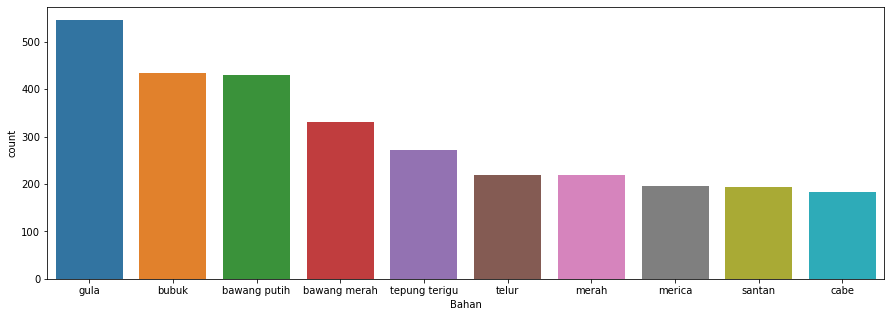

In [20]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'Bahan', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [21]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for Bahan in train.Bahan:
    ingr_list.append(bahan_parser(Bahan))

In [22]:
print (ingr_list[0])

['ayam', 'jeruk nipis', 'putih', 'laos', 'kunyit', 'jahe', 'bawang merah', 'cabai rawit', 'andaliman', 'daun jeruk', 'jeruk nipis']


In [23]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
print (l[0])

['ayam', 'jeruk nipis']


In [25]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [26]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print (df.count())

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print (df.count())

Ingredient1    75925
Ingredient2    75925
dtype: int64
Ingredient1    74813
Ingredient2    74813
dtype: int64


In [27]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    74813
Ingredient2    74813
f_x            74813
f_y            74813
f_xy           74813
pmi            74813
dtype: int64


In [28]:
df

,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
0,ayam,jeruk nipis,1884,501,34,0.991349
1,ayam,putih,1884,1183,24,-0.216161
2,ayam,laos,1884,77,5,0.947227
3,ayam,kunyit,1884,759,23,0.185087
4,ayam,jahe,1884,855,38,0.568079
...,...,...,...,...,...,...
75920,keju cheddar,oles,196,232,2,1.191042
75921,keju cheddar,kuning telur,196,313,6,1.990189
75922,alpukat,daun ketumbar,131,2,1,5.654402
75923,alpukat,bawang bombay,131,39,2,3.377135


In [29]:
#Eliminate rows for the same ingredient combinations
print (df.pmi.count())
df = df.drop_duplicates()
print (df.pmi.count())

#Sort df
df = df.sort_values('pmi',ascending='false')
df.head()

74813
24363


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
52852,bawang merah,susu,3197,1646,1,-4.253325
38150,cabe,tepung terigu,1836,2413,2,-3.388077
30604,coklat,merah,1153,1820,1,-3.333967
11551,cabai merah,susu,1150,1646,1,-3.230874
46483,bakar,tepung terigu,711,2413,1,-3.132552


In [30]:
df.to_csv('data/pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [31]:
df = pd.read_csv('data/pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('data/pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('data/pmi_ingredient_similarity_neg.csv')

In [32]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [33]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Bahan':ingr_list})
#print ingr_clean_df
print (ingr_clean_df)
ingr_clean_df.to_csv('data/ingredient_2_recipe_clean.csv')

                                                  Bahan
0     [ayam, jeruk nipis, putih, laos, kunyit, jahe,...
1     [tepung tapioka, bawang putih, kaldu bubuk, ca...
2     [kangkung, kacang, tauge, terong, kelapa, kela...
3     [kuning telur, putih telur, tambah, coklat, bu...
4     [telur, gula, emulsifier, tepung maizena, marg...
...                                                 ...
1348  [tepung terigu, vanili, gula, telur, sp, marga...
1349  [kelapa, daging sapi, asam, asam, larut, kaldu...
1350  [biang, tepung terigu, gula, telur, tepung ter...
1351  [tepung terigu, kuning telur, keju edam, gula,...
1352            [alpukat, daun ketumbar, bawang bombay]

[1353 rows x 1 columns]


In [34]:
from gensim.models import FastText

# Define your list of recipes (ingr_list) here

# Set up the FastText model
model = FastText(vector_size=300, window=5, min_count=1, sg=1)

# Build the vocabulary and train the model
model.build_vocab(corpus_iterable=ingr_list)
model.train(corpus_iterable=ingr_list, total_examples=len(ingr_list), epochs=105)

# Get the most similar ingredients to 'kol' or 'kubis'
similar_ingredients = model.wv.most_similar('kol')

# Print the similar ingredients
for ingredient, similarity in similar_ingredients:
    print(ingredient, similarity)

kecipir 0.6113241314888
pong 0.6067392826080322
toge 0.5995839834213257
sutra 0.5820479393005371
indomie 0.5777435898780823
buahisian 0.5736338496208191
koples 0.5666729807853699
kotor 0.5657349824905396
hokkian 0.5641156435012817
katsu 0.5633608102798462


In [35]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other
from gensim.models import Word2Vec

num_features = 250  # Word vector dimensionality
context = 2  # Context window size
downsampling = 1e-3  # Threshold for downsampling higher-frequency words
epochs = 75  # Number of training epochs

# Initialize and train the Word2Vec model
model = Word2Vec(ingr_list, vector_size=num_features, window=context, sample=downsampling)

# Increase the number of training epochs
model.train(ingr_list, total_examples=len(ingr_list), epochs=epochs)

# If you don't plan to train the model any further, calling
# init_sims will make the model more memory-efficient
model.init_sims(replace=True)

# Save the trained model
model.save("models/recom.model")

C:\Users\AMRINA\AppData\Local\Temp/ipykernel_2452/1162336370.py:18: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [36]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [37]:
flatten_list

['ayam',
 'jeruk nipis',
 'putih',
 'laos',
 'kunyit',
 'jahe',
 'bawang merah',
 'cabai rawit',
 'andaliman',
 'daun jeruk',
 'tepung tapioka',
 'bawang putih',
 'kaldu bubuk',
 'cabai',
 'bubuk',
 'kangkung',
 'kacang',
 'tauge',
 'terong',
 'kelapa',
 'kelapa parut',
 'cabai merah',
 'kemiri',
 'kencur',
 'gula merah',
 'sambal',
 'koples',
 'kacang tanah',
 'kuning telur',
 'putih telur',
 'tambah',
 'coklat',
 'oles',
 'sela',
 'telur',
 'gula',
 'emulsifier',
 'tepung maizena',
 'margarin',
 'pasta',
 'moka',
 'strawberry',
 'daging sapi',
 'serai',
 'daun salam',
 'asam jawa',
 'pandan',
 'kulit pastry',
 'x',
 'vla',
 'susu',
 'full',
 'cream',
 'dark',
 'cooking',
 'chocolate',
 'maizena',
 'gaplek',
 'singkong',
 'kering',
 'daging ayam',
 'bawang',
 'lengkuas',
 'kulit',
 'tepung',
 'rendam',
 'adon',
 'isi',
 'telur ayam',
 'kayu manis',
 'kapulaga',
 'cengkeh',
 'daun kari',
 'nasi',
 'beras jagung',
 'urap',
 'sayur',
 'lengkap',
 'tempe',
 'ikan asin',
 'terasi',
 'beras

In [38]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.similarity(i,i)})      
    except KeyError:
        pass

In [39]:
corpus_sim_dict

{'ayam': 1.0,
 'jeruk nipis': 1.0000001,
 'putih': 1.0,
 'laos': 1.0000001,
 'kunyit': 1.0,
 'jahe': 1.0,
 'bawang merah': 1.0,
 'cabai rawit': 1.0,
 'daun jeruk': 1.0,
 'tepung tapioka': 0.99999994,
 'bawang putih': 1.0,
 'kaldu bubuk': 0.99999994,
 'cabai': 1.0000001,
 'bubuk': 0.99999994,
 'kangkung': 1.0000001,
 'kacang': 1.0,
 'tauge': 1.0000001,
 'terong': 0.99999994,
 'kelapa': 1.0,
 'kelapa parut': 1.0,
 'cabai merah': 1.0,
 'kemiri': 1.0,
 'kencur': 1.0,
 'gula merah': 1.0,
 'sambal': 1.0,
 'kacang tanah': 1.0,
 'kuning telur': 1.0,
 'putih telur': 1.0,
 'tambah': 1.0,
 'coklat': 1.0,
 'oles': 1.0,
 'sela': 1.0,
 'telur': 1.0,
 'gula': 0.9999999,
 'emulsifier': 1.0,
 'tepung maizena': 1.0,
 'margarin': 1.0,
 'pasta': 0.99999994,
 'strawberry': 1.0,
 'daging sapi': 1.0,
 'serai': 1.0,
 'daun salam': 1.0000001,
 'asam jawa': 1.0,
 'pandan': 0.99999994,
 'vla': 0.99999994,
 'susu': 0.99999994,
 'full': 1.0000001,
 'cream': 0.99999994,
 'dark': 1.0,
 'cooking': 0.99999994,
 'choco

In [40]:
# Load the trained model
model = Word2Vec.load("models/recom.model")

# Obtain the most similar ingredients to 'kol' or 'kubis'
similar_ingredients = model.wv.most_similar('kol')

# Print the similar ingredients
for ingredient, similarity in similar_ingredients:
    print(ingredient, similarity)

tauge 0.8261410593986511
kangkung 0.7984956502914429
buncis 0.7955079674720764
kulit lumpia 0.792153537273407
soun 0.7746270298957825
sawi 0.7536159753799438
bakso sapi 0.7454076409339905
mentimun 0.7295763492584229
sawi putih 0.7268627882003784
selada 0.722800612449646


In [41]:
model.wv.most_similar('ayam')

[('paha ayam', 0.6243874430656433),
 ('ikan nila', 0.5956494808197021),
 ('tulang ayam', 0.5864537358283997),
 ('bunga kol', 0.571801483631134),
 ('ceker ayam', 0.5680147409439087),
 ('jamur', 0.5570679903030396),
 ('ikan tongkol', 0.553775429725647),
 ('fillet', 0.5428763031959534),
 ('ikan lele', 0.5195753574371338),
 ('bebek', 0.5161906480789185)]

In [42]:
model.wv.most_similar('kol')

[('tauge', 0.8261410593986511),
 ('kangkung', 0.7984956502914429),
 ('buncis', 0.7955079674720764),
 ('kulit lumpia', 0.792153537273407),
 ('soun', 0.7746270298957825),
 ('sawi', 0.7536159753799438),
 ('bakso sapi', 0.7454076409339905),
 ('mentimun', 0.7295763492584229),
 ('sawi putih', 0.7268627882003784),
 ('selada', 0.722800612449646)]

In [43]:
dictionary = corpora.Dictionary(ingr_list)
#print(dictionary)
print(dictionary.token2id)

{'andaliman': 0, 'ayam': 1, 'bawang merah': 2, 'cabai rawit': 3, 'daun jeruk': 4, 'jahe': 5, 'jeruk nipis': 6, 'kunyit': 7, 'laos': 8, 'putih': 9, 'bawang putih': 10, 'bubuk': 11, 'cabai': 12, 'kaldu bubuk': 13, 'tepung tapioka': 14, 'cabai merah': 15, 'gula merah': 16, 'kacang': 17, 'kacang tanah': 18, 'kangkung': 19, 'kelapa': 20, 'kelapa parut': 21, 'kemiri': 22, 'kencur': 23, 'koples': 24, 'sambal': 25, 'tauge': 26, 'terong': 27, 'coklat': 28, 'kuning telur': 29, 'oles': 30, 'putih telur': 31, 'sela': 32, 'tambah': 33, 'emulsifier': 34, 'gula': 35, 'margarin': 36, 'moka': 37, 'pasta': 38, 'strawberry': 39, 'telur': 40, 'tepung maizena': 41, 'asam jawa': 42, 'daging sapi': 43, 'daun salam': 44, 'serai': 45, 'chocolate': 46, 'cooking': 47, 'cream': 48, 'dark': 49, 'full': 50, 'kulit pastry': 51, 'maizena': 52, 'pandan': 53, 'susu': 54, 'vla': 55, 'x': 56, 'gaplek': 57, 'kering': 58, 'singkong': 59, 'bawang': 60, 'daging ayam': 61, 'lengkuas': 62, 'adon': 63, 'cengkeh': 64, 'daun kari

In [44]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1)]

In [45]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, model):

        self.model = model
        self.word_idf_weight = None
        self.vector_size = model.wv.vector_size

    def fit(self, docs):
        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer()
        tfidf.fit(text_docs)
        # if a word was never seen it is given idf of the max of known idf value
        max_idf = max(tfidf.idf_)
        self.word_idf_weight = defaultdict(
            lambda: max_idf,
            [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()],
        )
        return self

    def transform(self, docs):
        doc_word_vector = self.doc_average_list(docs)
        return doc_word_vector

    def doc_average(self, doc):
        mean = []
        for word in doc:
            if word in self.model.wv.index_to_key:
                mean.append(
                    self.model.wv.get_vector(word) * self.word_idf_weight[word]
                )

        if not mean:
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean

    def doc_average_list(self, docs):
        return np.vstack([self.doc_average(doc) for doc in docs])

In [46]:
def get_recommendations(N, scores, data, input_ingredients):
    # Sort the scores and get the indices of the top N recommendations
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:N]

    recommendations = []
    for index in top_indices:
        recipe_name = data.loc[index, "Judul"]
        recipe_ingredients = data.loc[index, "Bahan"]
        matching_ingredients = find_matching_ingredients(recipe_ingredients, input_ingredients)

        # Calculate the weighted similarity score based on the proportion of matching ingredients
        weight = len(matching_ingredients) / len(input_ingredients)
        weighted_score = scores[index] * weight

        recommendations.append((recipe_name, matching_ingredients, recipe_ingredients, weighted_score))

    return recommendations


def find_matching_ingredients(recipe_ingredients, input_ingredients):
    matching_ingredients = []
    for ingredient in recipe_ingredients:
        for input_ingredient in input_ingredients:
            if input_ingredient.lower() in ingredient.lower():
                matching_ingredients.append(ingredient)
                break

    return matching_ingredients

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [48]:
def get_and_sort_corpus(data):
    corpus_sorted = []
    for doc in data.parsed.values:
        sorted_doc = sorted(doc)
        corpus_sorted.append(sorted_doc)
    return corpus_sorted

In [49]:
from collections import defaultdict

In [50]:
def RecSys(Bahan, N=5):
    model = Word2Vec.load("models/word2vec.model")
    # normalize embeddings
    model.init_sims(replace=True)
    if model:
        print("Successfully loaded model")
        
    # load data
    data = pd.read_csv("data/resep_dataset2.csv")
    # parse ingredients
    data["parsed"] = data["Bahan"].apply(bahan_parser)
    # create corpus
    corpus = get_and_sort_corpus(data)
    # parse the ingredients using my ingredient_parser
    tfidf_vec_tr = TfidfEmbeddingVectorizer(model)
    tfidf_vec_tr.fit(corpus)
    doc_vec = tfidf_vec_tr.transform(corpus)
    doc_vec = [doc.reshape(1, -1) for doc in doc_vec]
    assert len(doc_vec) == len(corpus)

    # create embeddings for input text
    input_ingredients = Bahan.split(",")
    input_parsed = bahan_parser(input_ingredients)
    input_embedding = tfidf_vec_tr.transform([input_parsed])[0].reshape(1, -1)

    # get cosine similarity between input embedding and all the document embeddings
    cos_sim = map(lambda x: cosine_similarity(input_embedding, x)[0][0], doc_vec)
    scores = list(cos_sim)
    
    # Filter top N recommendations
    recommendations = get_recommendations(N, scores, data, input_ingredients)
    
    return recommendations

In [51]:
input = "brokoli,wortel,kubis,sosis"
recs = RecSys(input)
recs

Successfully loaded model


C:\Users\AMRINA\AppData\Local\Temp/ipykernel_2452/2546433953.py:4: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


[('Resep Sop Sayur',
  [],
  ' Kaldu ayam  -  1,2 liter  Ayam fillet, potong kotak  -  100 gram Sosis, potong-potong dan belah ujungnya jadi 4 bagian  -  2 buah Kubis, potong-potong  -  4 lembar Kentang, potong kotak  -  1 buah Wortel, potong-potong  -  1 buah Bakso ayam, potong dan belah ujungnya jadi 4 bagian  -  6 butir Bunga kol, potong perkuntum  -  100 gram Brokoli, potong perkuntum  -  100 gram Tomat, potong jadi 8 iris  -  1 buah  Seledri, diiikat simpul  -  1 batang Daun bawang, diikat simpul  -  1 batang Garam  -   2 sdt Gula pasir   -  1 sdt Pala bubuk  -  1/4 sdt',
  0.0),
 ('Resep Nasi Tim Sayuran',
  [],
  'NASI TIM: Beras  -  200 gram Air  -  800 ml Garam  -  1  SAYURAN: Brokoli  -  1 bonggol Wortel  -  3 buah Udang, kupas  -  100 gram Bawang putih  -  3 siung Kecap manis  -  1 sdm Saus tiram  -  1 sdm Kecap asin  -  1 sdt Garam  -  1 sdt Gula pasir  -  2 sdt Merica bubuk  -  1/4 sdt',
  0.0),
 ('Resep Bakwan Mie',
  [],
  ' Mie telur  -  150 gram Wortel, potong korek ap